# (07) Neural analysis (KABA)

**Motivation**: <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-MTMST/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-MTMST/figs')
tmp_dir = os.path.join(git_dir, 'jb-MTMST/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_MTMST'))
from vae.train_vae import TrainerVAE, ConfigTrainVAE
from vae.vae2d import VAE, ConfigVAE
from figures.fighelper import *
from analysis.glm import *


# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
path = results_dir()
path = pathlib.Path(path)

trainer_paths = set()
pat = '**/Trainer' # '**/*fixate1*/**/Trainer'
for p in path.rglob(pat):
    if p.is_dir():
        trainer_paths.add(str(p))
trainer_paths = sorted(trainer_paths)

In [3]:
for fit_path in trainer_paths:
    fit_name = fit_path.split('/')[-2]
    
    if 'fixate1_nf-420_beta-0.01' not in fit_name:
        continue
    
    f = pjoin(tmp_dir, 'trainer_analysis', fit_name)
    f = f"{f}.npy"
    if os.path.isfile(f):
        everything = np.load(f, allow_pickle=True).item()
        break

In [4]:
fit_name

'fixate1_nf-420_beta-0.01_(2023_04_30,07:42)'

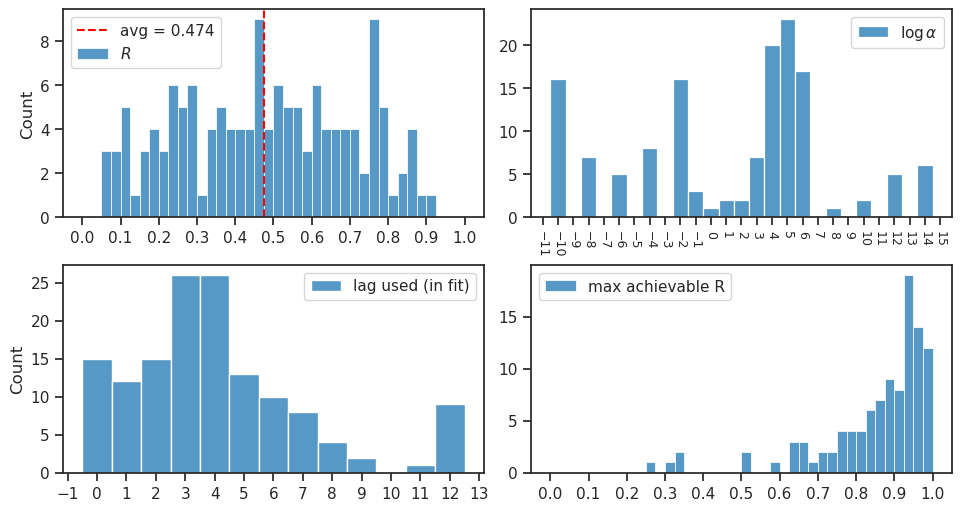

141

In [5]:
df, df_all, ro_all, args, tr = summarize_neural_fits(
    fit_name=fit_name, device='cuda:1')
_ = show_neural_results(df)
len(df)

In [6]:
rng = get_rng()

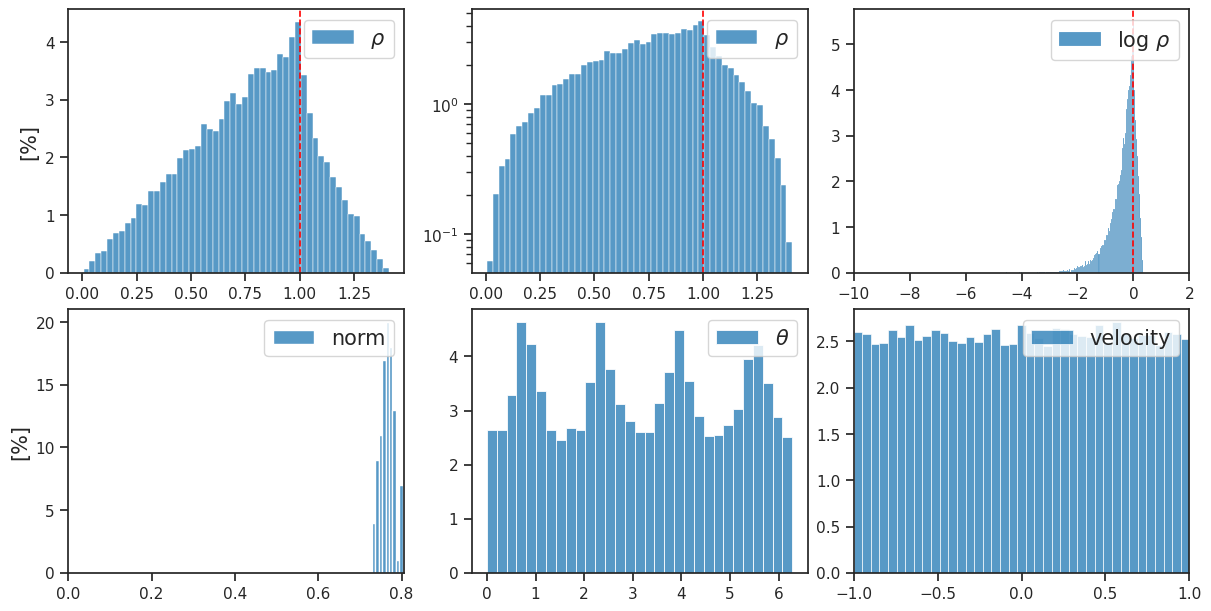

In [7]:
x = rng.uniform(-1, 1, (100, 2, 17, 17))
plot_opticflow_hist(x);

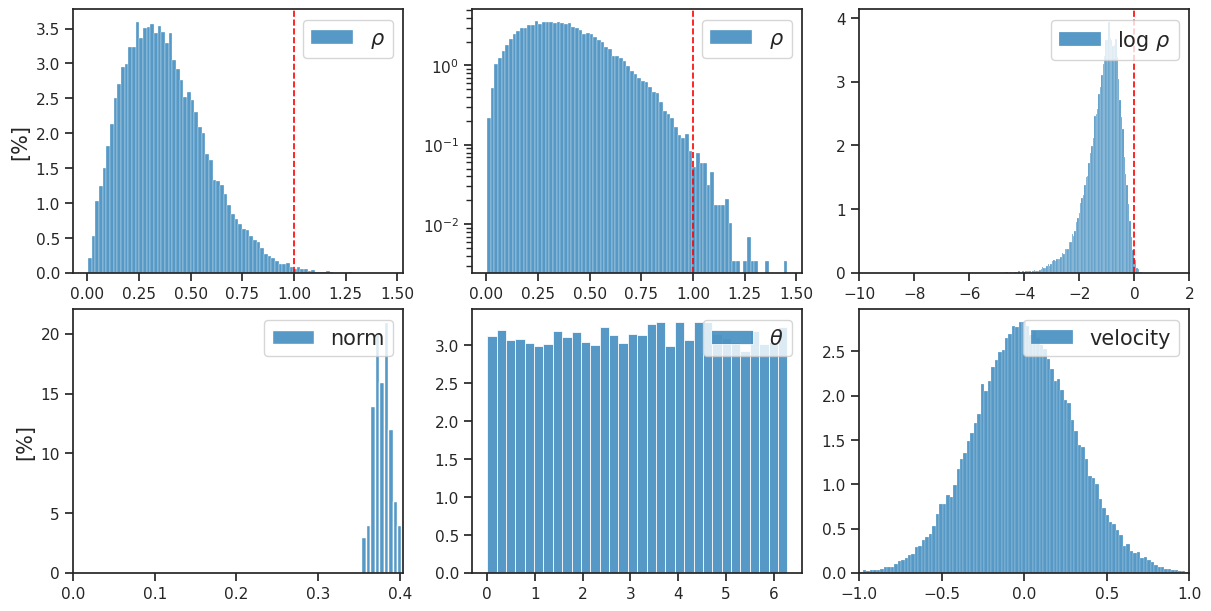

In [8]:
x = rng.normal(0, 0.3, (100, 2, 17, 17))
plot_opticflow_hist(x);

In [6]:
expt, cell = 'clu267', 4
ro = ro_all[f'YUWEI_{expt}']
neural_data = ro.validate(cell)

neural_data['y'].sum() / (len(neural_data['y']) * 25e-3)

19.790658905195265

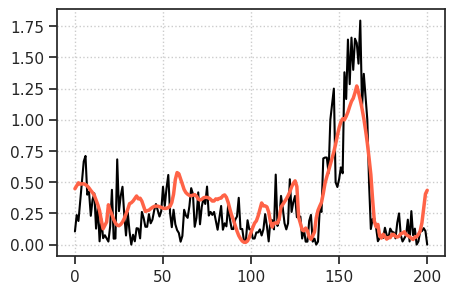

In [7]:
pred = ro.mod[cell].predict(neural_data['x_tst'])

plt.plot(neural_data['y_tst'], color='k', lw=1.5)
plt.plot(pred, color='tomato', lw=2.5)
plt.grid()
plt.show()

In [8]:
list(neural_data)

['x', 'y', 'x_tst', 'y_tst']

In [9]:
neural_data['x'].shape

(36591, 420)

In [10]:
pred = ro.mod[cell].predict(neural_data['x'])
ro.stim[ro.good].shape, pred.shape

((36591, 2, 17, 17), (36591,))

In [11]:
sta_model = compute_sta(
    n_lags=0,
    stim=ro.stim[ro.good],
    spks=pred.reshape(-1, 1),
)

/home/hadi/Dropbox/git/_MTMST/analysis/linear.py:293: RuntimeWarning: NaN in STA
  warnings.warn("NaN in STA", RuntimeWarning)


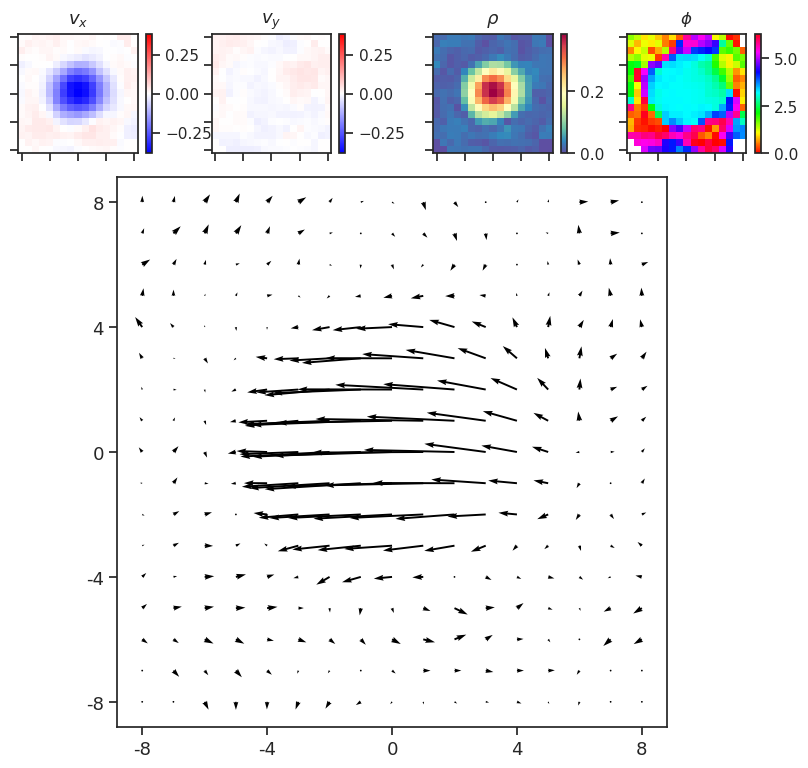

In [12]:
show_opticflow_full(sta_model.squeeze());

In [11]:
scale = 1
batch_size = 300

In [12]:
x, z = [], []
for i in range(10000):
    _x = rng.normal(0, scale, (batch_size, 2, 17, 17))
    _, _z, *_ = tr.model.xtract_ftr(tr.to(_x))
    _z = torch.cat(_z, dim=1).squeeze()
    z.append(to_np(_z))
    x.append(to_np(_x))
x, z = cat_map([x, z])
x.shape, z.shape

((3000000, 2, 17, 17), (3000000, 420))

In [13]:
fr_all, kappa = {}, {}
for ro in tqdm(ro_all.values()):
    for idx, m in ro.mod.items():
        key = f"{ro.expt}_{idx}"
        fr = m.predict(z)
        k = np.einsum(
            't, tijk -> ijk',
            fr, x,
        )
        k /= sp_lin.norm(k)
        fr_all[key] = fr
        kappa[key] = k

100%|██████████| 60/60 [09:43<00:00,  9.73s/it]


In [16]:
titles = np.array([
    f"{name}, r = {r}" for name, r in
    zip(list(kappa), np.round(df['perf'].values, 2))
])
kappa_cat = np.stack(list(kappa.values()))
kappa_cat.shape

(141, 2, 17, 17)

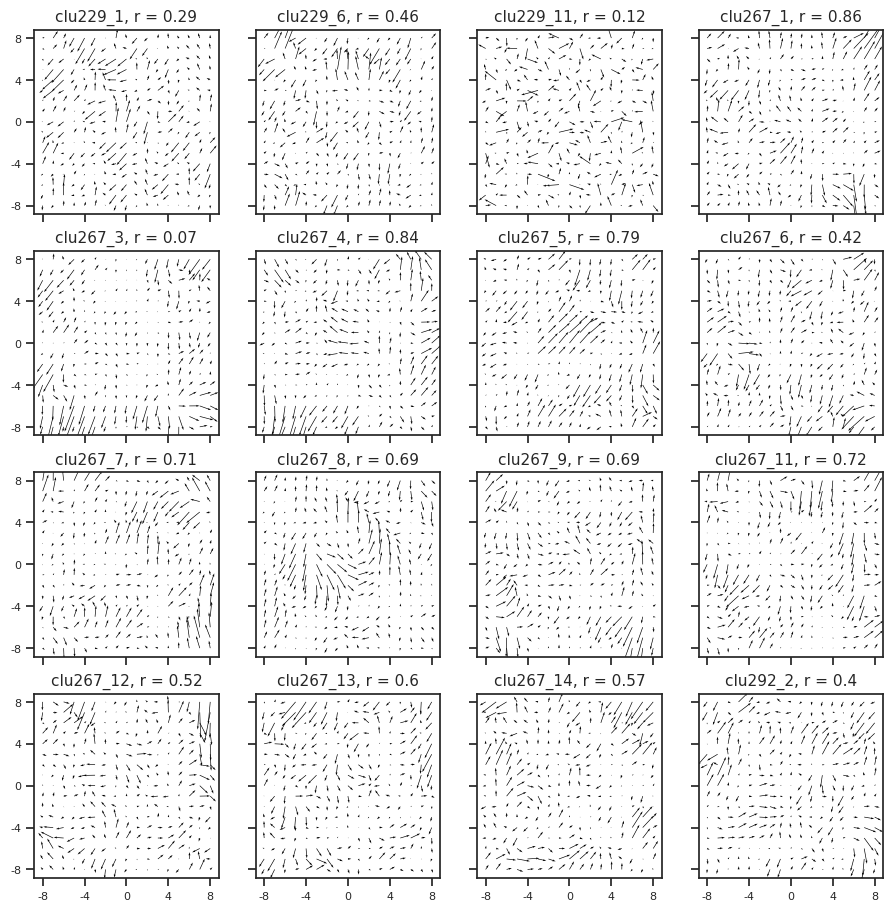

In [17]:
t = 64
intvl = range(t, t + 16)
fig, axes = show_opticflow(kappa_cat[intvl], titles=titles[intvl])

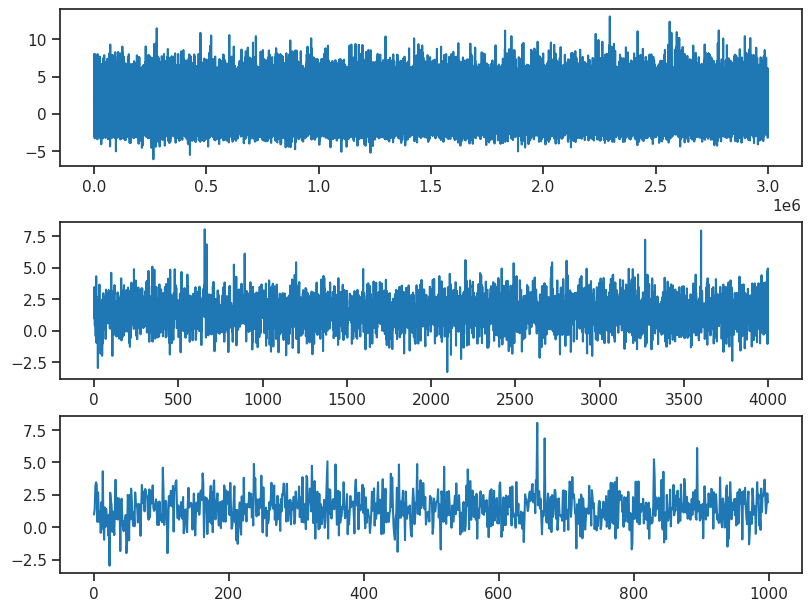

In [26]:
fig, axes = create_figure(3, 1, (8, 6), layout='constrained')
axes[0].plot(fr_all['clu267_4']);
axes[1].plot(fr_all['clu267_4'][1000:5000]);
axes[2].plot(fr_all['clu267_4'][1000:2000]);

In [6]:
list(everything)

['val',
 'loss',
 'data_trn',
 'data_vld',
 'data_tst',
 'importances_mu',
 'importances_sd',
 'f']

In [10]:
poisson = False
rng = get_rng()
fr_all, kappa = {}, {}
for ro in tqdm(ro_all.values()):
    for idx, m in ro.mod.items():
        key = f"{ro.expt}_{idx}"
        fr = m.predict(everything['data_trn']['z'])
        if poisson:
            fr = np.maximum(fr, 0)
            fr = rng.poisson(fr)
        k = np.einsum(
            't, tijk -> ijk',
            fr, everything['data_trn']['x'],
        )
        k /= sp_lin.norm(k)
        fr_all[key] = fr
        kappa[key] = k

100%|██████████| 60/60 [01:25<00:00,  1.42s/it]


In [12]:
titles = np.array([
    f"{name}, r = {r}" for name, r in
    zip(list(kappa), np.round(df['perf'].values, 2))
])
kappa_cat = np.stack(list(kappa.values()))
kappa_cat.shape

(141, 2, 17, 17)

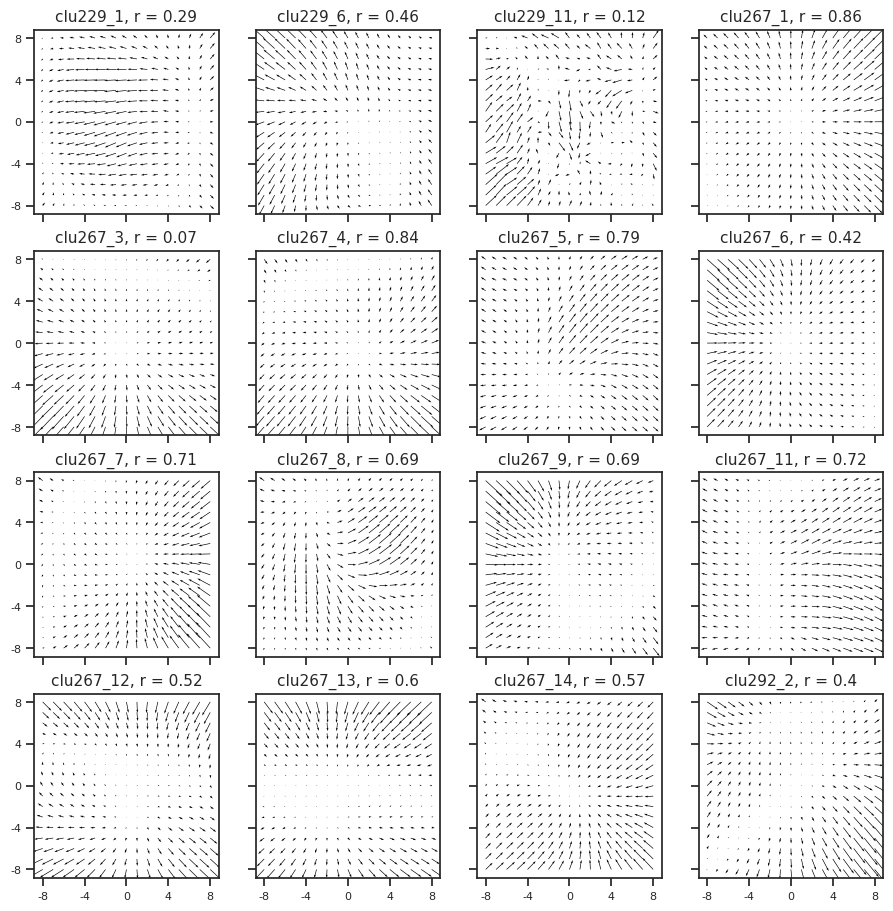

In [13]:
t = 64
intvl = range(t, t + 16)
fig, axes = show_opticflow(kappa_cat[intvl], titles=titles[intvl])

In [34]:
expt, cell = 'clu267', 4
ro = ro_all[f'YUWEI_{expt}']
neural_data = ro.validate(cell)

neural_data['y'].sum() / (len(neural_data['y']) * 25e-3)

19.790658905195265

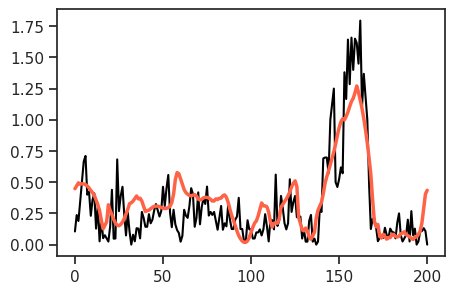

In [35]:
pred = ro.mod[cell].predict(neural_data['x_tst'])

plt.plot(neural_data['y_tst'], color='k', lw=1.5)
plt.plot(pred, color='tomato', lw=2.5)

In [36]:
r = sp_stats.pearsonr(neural_data['y_tst'], pred)[0]
r2 = sk_metric.r2_score(neural_data['y_tst'], pred) * 100
r, r2

(0.8272493373817079, 66.6536822760063)

In [37]:
r / np.sqrt(ro_all['YUWEI_clu267'].max_perf[cell])

0.8442991536703013

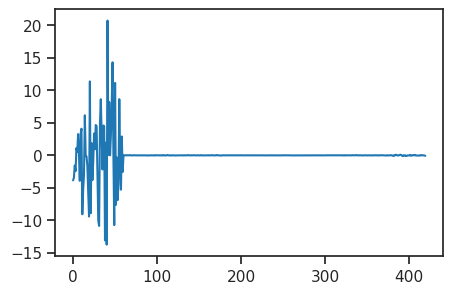

In [13]:
c = ro.mod[cell].coef_
plt.plot(c);

In [14]:
%%time

perm = sk_inspect.permutation_importance(
    estimator=ro.mod[cell],
    X=neural_data['x_tst'],
    y=neural_data['y_tst'],
    n_repeats=10,
    random_state=0,
)
perm_mu = np.maximum(0, perm['importances_mean'])
perm_sd = perm['importances_std']

CPU times: user 1min 7s, sys: 21.8 ms, total: 1min 7s
Wall time: 3.38 s


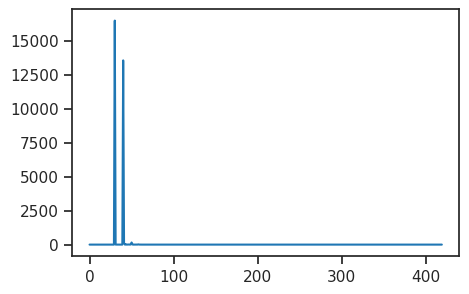

In [15]:
plt.plot(perm_mu)

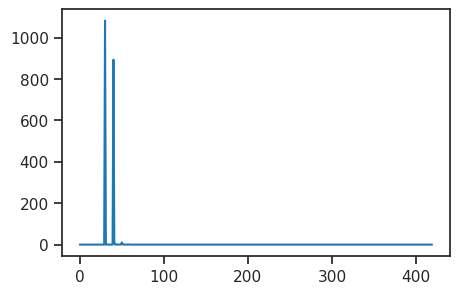

In [16]:
plt.plot(perm_sd)

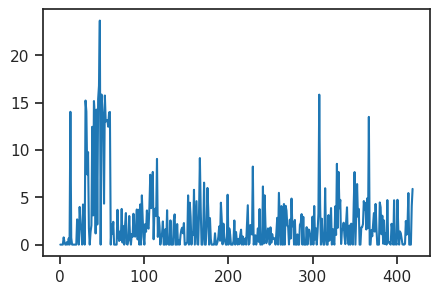

In [17]:
plt.plot(perm_mu / perm_sd)

In [18]:
p = perm_mu / perm_mu.sum()

In [19]:
1 - entropy_normalized(p, axis=0)

0.8724815295829532

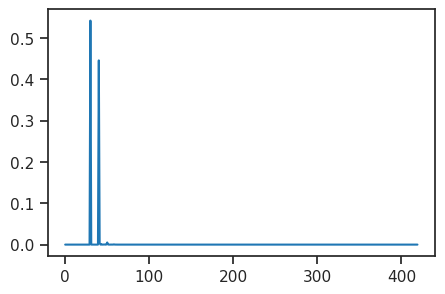

In [20]:
plt.plot(p)

In [21]:
important_latents = np.argsort(p)[::-1]
important_latents[:5]

array([30, 40, 50, 41, 43])

In [22]:
np.round(p[important_latents], 3)[:80]

array([0.542, 0.446, 0.005, 0.004, 0.001, 0.001, 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ])

In [49]:
val, loss = tr.validate(use_ema=False)
print({k: v.mean() for k, v in loss.items()})

{'epe': 0.25095394, 'kl': 77.54336, 'kl_diag': 0.18462704}

In [50]:
list(val)

['x_sample',
 'z_sample',
 'z_vld',
 'z_tst',
 'regr/r',
 'regr/r2',
 'regr/d',
 'regr/c',
 'r',
 'r2',
 'd',
 'c',
 'regr/aux/r',
 'regr/aux/r2',
 'regr/aux/d',
 'regr/aux/c',
 'regr/mi',
 'regr/mi_norm',
 'regr/mig',
 'fig/sample',
 'fig/regression',
 'fig/bar',
 'fig/bar_aux',
 'fig/mutual_info']

In [51]:
val['regr/mi'].shape

(11, 420)

array([30, 40, 50, 41, 43, 58])

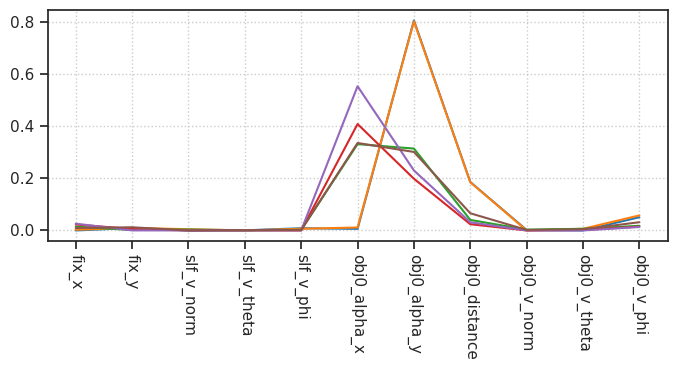

In [54]:
fig, ax = create_figure(1, 1, (8, 3))
for i in range(6):
    ax.plot(
        val['regr/mi'][:, important_latents[i]],
        label=f'z={important_latents[i]}',
        color=f'C{i}',
    )
ax.set(xticks=range(11), xticklabels=tr.dl_tst.dataset.f)
ax.tick_params(axis='x', rotation=-90)
# ax.locator_params(axis='x', nbins=11)
ax.grid()
plt.show()

In [55]:
list(val)

['x_sample',
 'z_sample',
 'z_vld',
 'z_tst',
 'regr/r',
 'regr/r2',
 'regr/d',
 'regr/c',
 'r',
 'r2',
 'd',
 'c',
 'regr/aux/r',
 'regr/aux/r2',
 'regr/aux/d',
 'regr/aux/c',
 'regr/mi',
 'regr/mi_norm',
 'regr/mig',
 'fig/sample',
 'fig/regression',
 'fig/bar',
 'fig/bar_aux',
 'fig/mutual_info']

In [56]:
from analysis.linear import mi_analysis

In [58]:
%%time

mi_output = mi_analysis(
    z=val['z_vld'],
    g=tr.dl_vld.dataset.g_aux,
)

CPU times: user 29.4 s, sys: 24.2 s, total: 53.6 s
Wall time: 6min 5s


In [59]:
list(mi_output)

['mi', 'mi_norm', 'mig']

In [61]:
.shape

(22, 420)

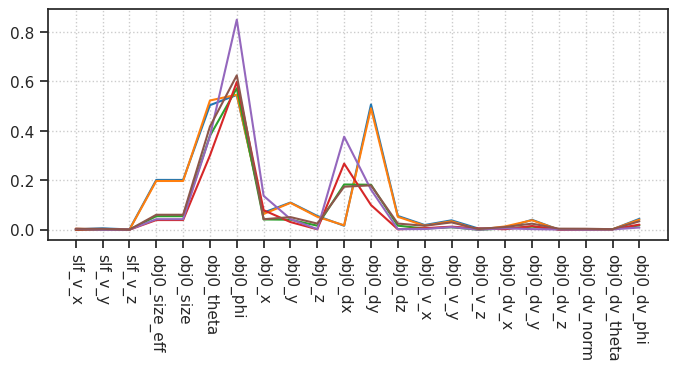

In [63]:
fig, ax = create_figure(1, 1, (8, 3))
for i in range(6):
    ax.plot(
        mi_output['mi'][:, important_latents[i]],
        label=f'z={important_latents[i]}',
        color=f'C{i}',
    )
labels = tr.dl_tst.dataset.f_aux
ax.set(xticks=range(len(labels)), xticklabels=labels)
ax.tick_params(axis='x', rotation=-90)
# ax.locator_params(axis='x', nbins=11)
ax.grid()
plt.show()

In [65]:
list(everything)

['val',
 'loss',
 'data_trn',
 'data_vld',
 'data_tst',
 'importances_mu',
 'importances_sd',
 'f']

In [66]:
everything['importances_mu'].shape

(33, 420)

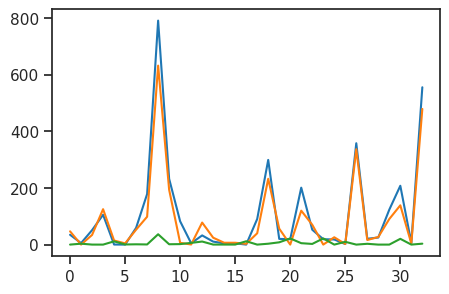

In [68]:
plt.plot(everything['importances_mu'][:, important_latents[:3]])

In [83]:
everything['importances_mu'].shape

(33, 420)

In [74]:
the_importance = everything['importances_mu'] @ perm_mu
the_importance /= sum(the_importance)
the_importance.shape

(33,)

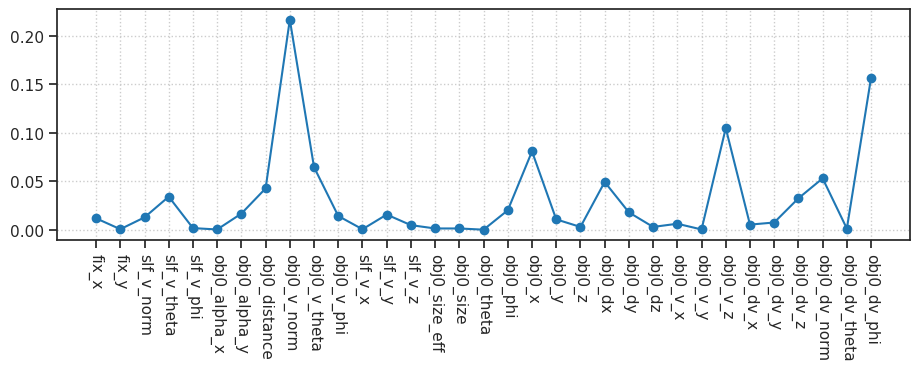

In [82]:
fig, ax = create_figure(1, 1, (11, 3))
plt.plot(the_importance, marker='o')
labels = tr.dl_tst.dataset.f + tr.dl_tst.dataset.f_aux
ax.set(xticks=range(len(labels)), xticklabels=labels)
ax.tick_params(axis='x', rotation=-90)
ax.grid()
plt.show()

In [109]:
np.min(everything['importances_mu'])

-7.09305187580167e-05

In [26]:
p_z_given_neuron = perm_mu / perm_mu.sum()
p_g_given_z = np.maximum(0, everything['importances_mu'])
p_g_given_z = p_g_given_z / p_g_given_z.sum(0, keepdims=True)
p_g_given_neuron = p_g_given_z @ p_z_given_neuron

In [27]:
p_z_given_neuron.sum(), p_g_given_neuron.sum()

(1.0000000000000002, 1.0)

In [29]:
p_g_given_z.sum(0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

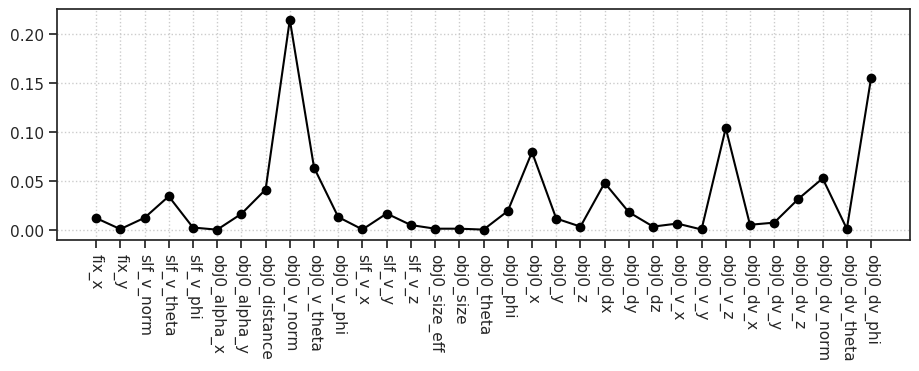

In [30]:
fig, ax = create_figure(1, 1, (11, 3))
plt.plot(p_g_given_neuron, marker='o', color='k')
labels = tr.dl_tst.dataset.f + tr.dl_tst.dataset.f_aux
ax.set(xticks=range(len(labels)), xticklabels=labels)
ax.tick_params(axis='x', rotation=-90)
ax.grid()
plt.show()

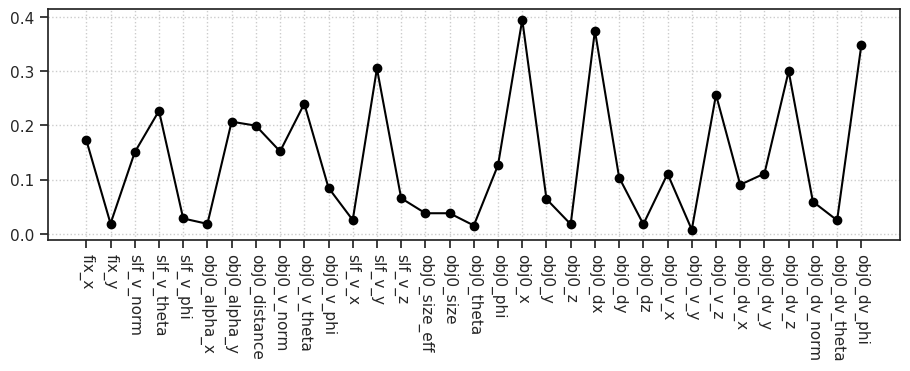

In [143]:
# was wrong (before debugging)

In [31]:
selected = [0, 1, 11, 12, 13, 18, 19, 20, 24, 25, 26]

In [32]:
list(np.array(labels)[selected])

['fix_x',
 'fix_y',
 'slf_v_x',
 'slf_v_y',
 'slf_v_z',
 'obj0_x',
 'obj0_y',
 'obj0_z',
 'obj0_v_x',
 'obj0_v_y',
 'obj0_v_z']

In [33]:
p_z_given_neuron = perm_mu / perm_mu.sum()
p_g_given_z = np.maximum(0, everything['importances_mu'])[selected]
p_g_given_z = p_g_given_z / p_g_given_z.sum(0, keepdims=True)
p_g_given_neuron = p_g_given_z @ p_z_given_neuron

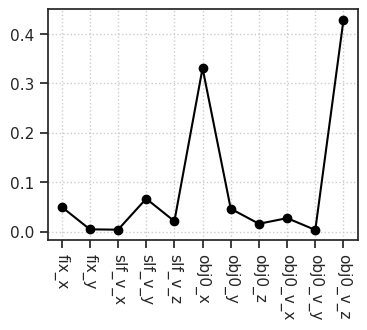

In [34]:
fig, ax = create_figure(1, 1, (4, 3))
plt.plot(p_g_given_neuron, marker='o', color='k')
labels = tr.dl_tst.dataset.f + tr.dl_tst.dataset.f_aux
ax.set(xticks=range(len(selected)), xticklabels=list(np.array(labels)[selected]))
ax.tick_params(axis='x', rotation=-90)
ax.grid()
plt.show()

In [35]:
p_g_given_neuron.sum()

1.0000000000000004

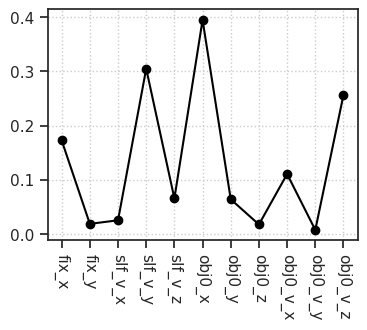

In [181]:
# was wrong (before debug)

In [136]:
p_neuron_given_z = perm_mu / perm_mu.sum()
p_z_given_g = np.maximum(0, everything['importances_mu'])
p_z_given_g = p_z_given_g / p_z_given_g.sum(0, keepdims=True)
p_neuron_given_g = p_z_given_g @ p_neuron_given_z

In [137]:
p_z_given_g.shape, p_neuron_given_z.shape

((33, 420), (420,))

In [138]:
p_z_given_g.sum(0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

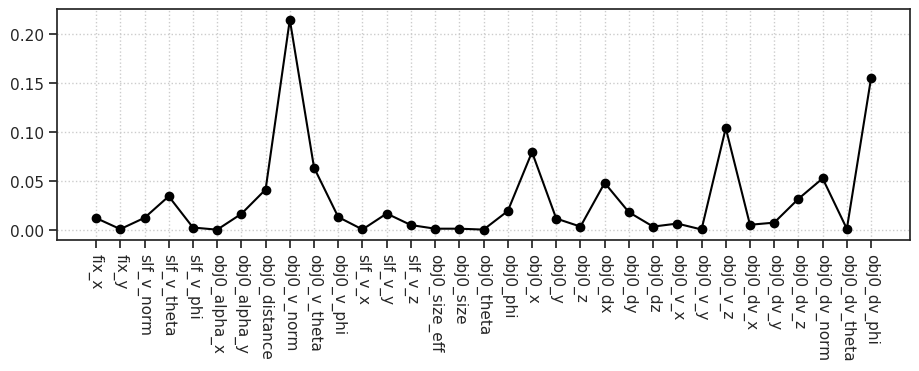

In [142]:
fig, ax = create_figure(1, 1, (11, 3))
plt.plot(p_neuron_given_g, marker='o', color='k')
labels = tr.dl_tst.dataset.f + tr.dl_tst.dataset.f_aux
ax.set(xticks=range(len(labels)), xticklabels=labels)
ax.tick_params(axis='x', rotation=-90)
ax.grid()
plt.show()

## MI

In [ ]:
f = tr.dl_vld.dataset.f + tr.dl_vld.dataset.f_aux
g = np.concatenate([
    tr.dl_vld.dataset.g,
    tr.dl_vld.dataset.g_aux,
], axis=1)
g_tst = np.concatenate([
    tr.dl_tst.dataset.g,
    tr.dl_tst.dataset.g_aux,
], axis=1)

In [82]:
val, loss = tr.validate(use_ema=False)

In [86]:
val['regr/mi'].shape

(11, 420)

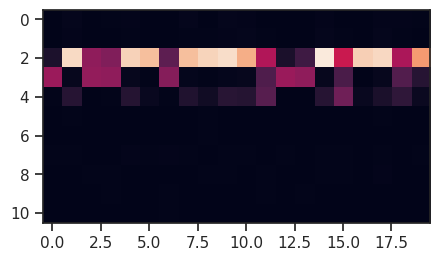

In [100]:
plt.imshow(val['regr/mi'][:, important_latents[:20]])

In [99]:
tr.dl_tst.dataset.f

['fix_x',
 'fix_y',
 'slf_v_norm',
 'slf_v_theta',
 'slf_v_phi',
 'obj0_alpha_x',
 'obj0_alpha_y',
 'obj0_distance',
 'obj0_v_norm',
 'obj0_v_theta',
 'obj0_v_phi']

In [ ]:

    everything = {
        'val': val,
        'loss': loss,
        'data_trn': data_trn,
        'data_vld': data_vld,
        'data_tst': data_tst,
        'importances_mu': importances_mu,
        'importances_sd': importances_sd,
        'f': f,
    }
    save_obj(
        obj=everything,
        file_name=fit_name,
        save_dir=pjoin(tmp_dir, 'trainer_analysis'),
        verbose=True,
        mode='npy',
    )

    torch.cuda.empty_cache()

In [30]:
for fit_path in trainer_paths:
    fit_name = fit_path.split('/')[-2]
    
    if 'vanilla' not in fit_name:
        continue
    
    f = pjoin(tmp_dir, 'trainer_analysis', fit_name)
    f = f"{f}.npy"
    if os.path.isfile(f):
        everything = np.load(f, allow_pickle=True).item()
        break

In [31]:
fit_name

'vanilla_fixate1_nf-420_beta-0.15_(2023_05_02,15:15)'

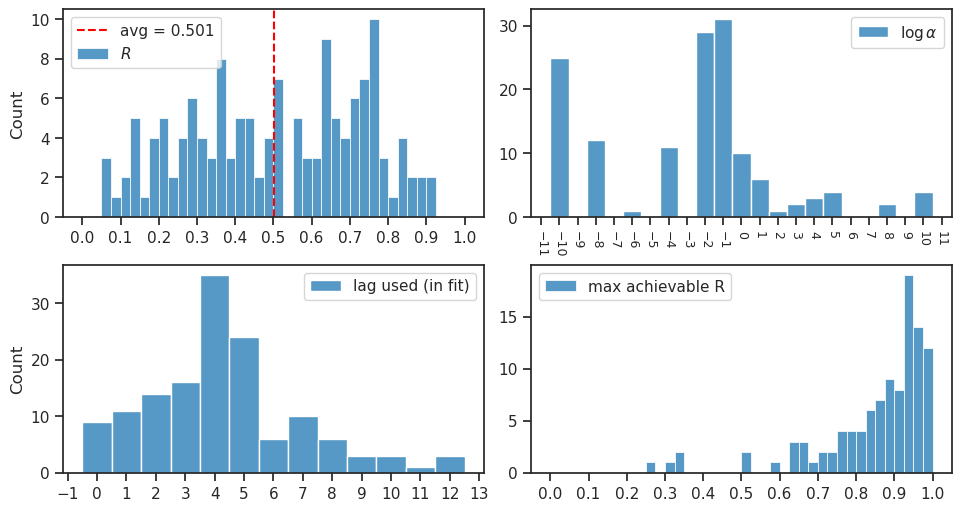

141

In [32]:
df, df_all, ro_all, args, tr = summarize_neural_fits(
    fit_name=fit_name, device='cuda:1')
_ = show_neural_results(df)
len(df)

In [33]:
list(everything)

['val',
 'loss',
 'data_trn',
 'data_vld',
 'data_tst',
 'importances_mu',
 'importances_sd',
 'f']

In [34]:
poisson = False
rng = get_rng()
fr_all, kappa = {}, {}
for ro in tqdm(ro_all.values()):
    for idx, m in ro.mod.items():
        key = f"{ro.expt}_{idx}"
        fr = m.predict(everything['data_trn']['z'])
        if poisson:
            fr = np.maximum(fr, 0)
            fr = rng.poisson(fr)
        k = np.einsum(
            't, tijk -> ijk',
            fr, everything['data_trn']['x'],
        )
        k /= sp_lin.norm(k)
        fr_all[key] = fr
        kappa[key] = k

100%|██████████| 60/60 [01:23<00:00,  1.39s/it]


In [35]:
titles = np.array([
    f"{name}, r = {r}" for name, r in
    zip(list(kappa), np.round(df['perf'].values, 2))
])
kappa_cat = np.stack(list(kappa.values()))
kappa_cat.shape

(141, 2, 17, 17)

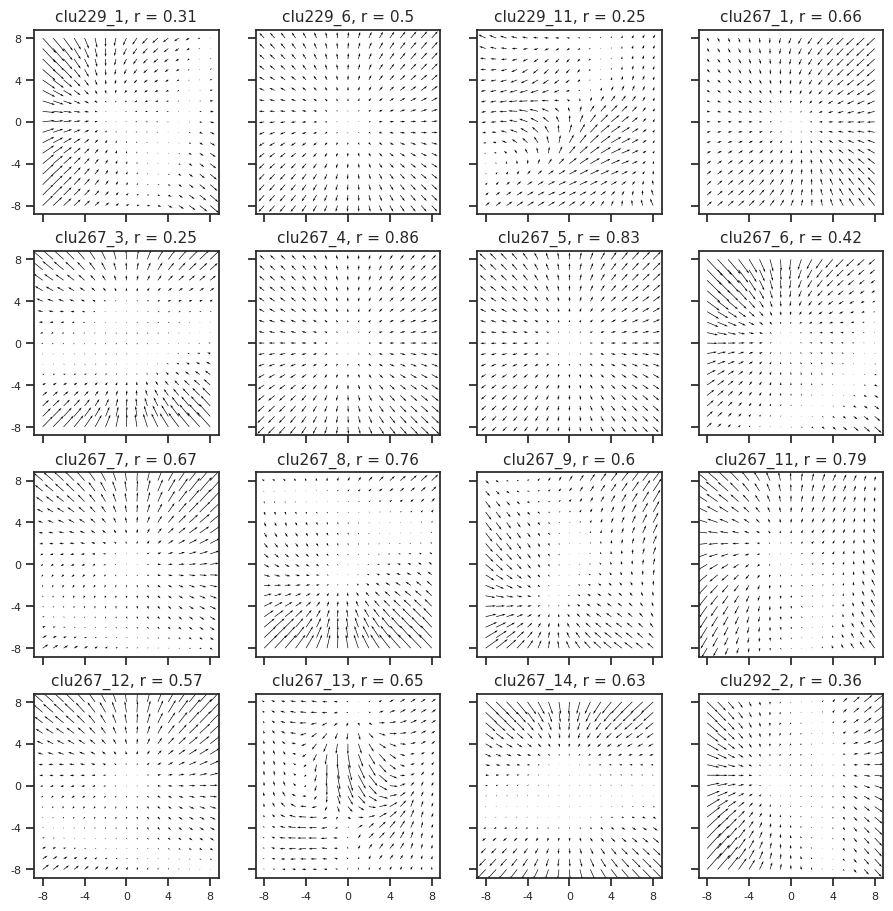

In [36]:
t = 64
intvl = range(t, t + 16)
fig, axes = show_opticflow(kappa_cat[intvl], titles=titles[intvl])

In [37]:
expt, cell = 'clu267', 4
ro = ro_all[f'YUWEI_{expt}']
neural_data = ro.validate(cell)

neural_data['y'].sum() / (len(neural_data['y']) * 25e-3)

19.790658905195265

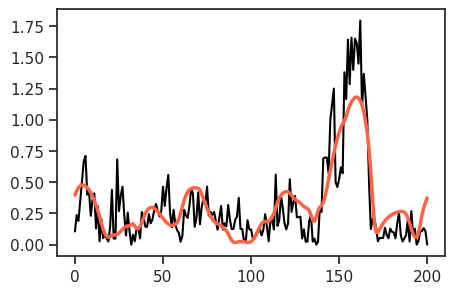

In [38]:
pred = ro.mod[cell].predict(neural_data['x_tst'])

plt.plot(neural_data['y_tst'], color='k', lw=1.5)
plt.plot(pred, color='tomato', lw=2.5)

In [39]:
r = sp_stats.pearsonr(neural_data['y_tst'], pred)[0]
r2 = sk_metric.r2_score(neural_data['y_tst'], pred) * 100
r, r2

(0.8420708264763723, 70.09796941862217)

In [40]:
r / np.sqrt(ro_all['YUWEI_clu267'].max_perf[cell])

0.859426117371917

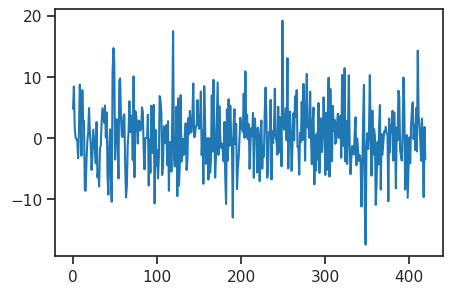

In [41]:
c = ro.mod[cell].coef_
plt.plot(c);

In [42]:
perm = sk_inspect.permutation_importance(
    estimator=ro.mod[cell],
    X=neural_data['x_tst'],
    y=neural_data['y_tst'],
    n_repeats=10,
    random_state=0,
)
perm_mu = np.maximum(0, perm['importances_mean'])
perm_sd = perm['importances_std']

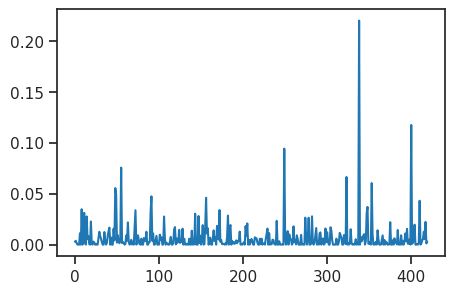

In [43]:
plt.plot(perm_mu)

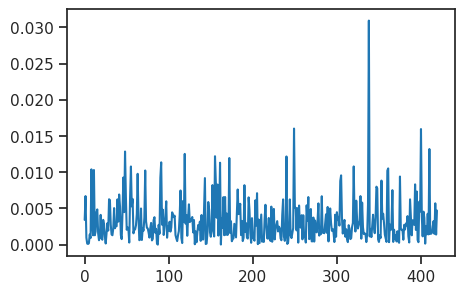

In [44]:
plt.plot(perm_sd)

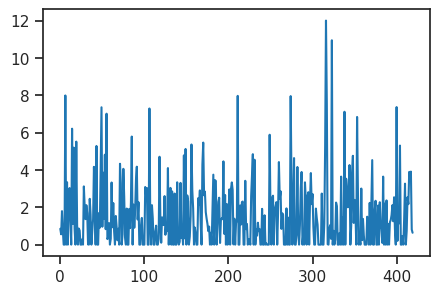

In [45]:
plt.plot(perm_mu / perm_sd)

In [46]:
p = perm_mu / perm_mu.sum()

In [47]:
1 - entropy_normalized(p, axis=0)

0.19283605758059563

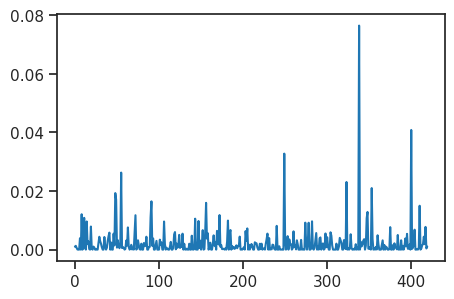

In [48]:
plt.plot(p)

In [49]:
important_latents = np.argsort(p)[::-1]
important_latents[:5]

array([338, 400, 249,  55, 323])